<hr>

# Probabilistic Pattella
_A brief introduction to multi-level models, probabilistic programming, and limpet morphometrics._

<hr>
Falk Mielke, FunMorph, Universiteit Antwerpen



You can download this notebook [here](user://notebooks/Probabilistic_Patella.ipynb?download&target=_blank).

Based on a seminar I hosted in 2017.
First posted 2019/09/16. Last modified 2019/09/27.

<br> python references:
<br>[statsmodels](http://statsmodels.sourceforge.net/devel/glm.html?download&target=_blank)
<br>[pymc3](https://docs.pymc.io/?download&target=_blank)



In this notebook, I outline my approach to statistical modeling. 
I use a data set on limpet morphometry, and will go through the process of describing these animals' characteristic shell dimensions with classical and probabilistic models.

The process covers a huge amount of details, some of which I discuss too briefly. There is always more that could be added, and I might decide to do so in the future. Of course, I cannot compete with text books in the field, some of which I will reference throughout the text below. In contrast to the more theoretical of the text books, the present demonstration focuses on the practical application of modeling tools in python. 

Enjoy the tour, and please leave comments below!


# Table of Content <a class="anchor" id="toc"></a>


- [Introduction](#intro)
- [Data Exploration](#exploration)
- [Model Design](#design)
- [StatsModels Generalization](#oop)
- [Probabilistic Modeling](#probabilistics)
- [Generalized Probabilistic Model Construction](#oop_probabilistics)
- [Model Comparison](#comparison)
- [Conclusions](#conclusions)
- [Comments](#comments)<br>

<hr>

Python libraries that are required below:

In [1]:
%matplotlib inline
# embed image
from IPython.display import Image

# data operations
import numpy as NP # numeric python / working with data arrays
import pandas as PD # data frames
PD.set_option('precision', 2)
    
# PCA
import scipy.linalg as LA # linear algebra

# statistics
import scipy.stats as STATS

# plotting
import matplotlib.pyplot as MPP
import matplotlib as MP
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as SB

# GLM packages
import statsmodels.api as SM
import statsmodels.formula.api as SMF # frequentist
import pymc3 as PM # bayesian
import patsy as PA
import theano as TH
import theano.tensor as TT

# plotting parameters
the_font = MP.font_manager.FontProperties( \
                                      family = 'DejaVu sans' \
                                    , weight = 'normal' \
                                    , size   = 14 \
                                    )

MPP.rcParams.update(**{ \
                  'font.family': the_font.get_name() \
                , 'font.weight': the_font.get_weight() \
                , 'font.size': the_font.get_size() \
                })


<hr>

# Introduction <a class="anchor" id="intro"></a> 
([^](#toc) top) 

## Why Another GL(M)M Tutorial?

Numerous tutorials exist that handle "mixed models", better called hierarchical or multi-level models. 
They come with considerable variation in terminology, especially when refering to Frequentist and Bayesian methods. 

The ones that primed me are from a series by Thomas Wiecki, who uses `pymc3`. For example
- [https://twiecki.io/blog/2014/03/17/bayesian-glms-3](https://twiecki.io/blog/2014/03/17/bayesian-glms-3?target=_blank)
- [https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered?target=_blank)

My favorite text book on statistics is this one:
- [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/?target=_blank)
<br> (see also [code examples](https://github.com/pymc-devs/resources/tree/master/Rethinking?target=_blank))

I will stay in `Python`, because I am used to it. An advantage is the relatively intuitive and understandable syntax. I tend to make variable names explicit and consistent, and will comment a lot herein.


You will find little here that has not been covered elsewhere. However, the method is fundamental, and there are a lot of design choices that seem trivial, but _can_ fundamentally affect the outcome of the model. In many examples, these choices will not matter, but in principle, they can. Thus, model choice usually is an iterative process, and I will present some best practices that help me to organize the journeys through the modeling world. 

**To summarize, this post attempts to be an extensive, application-focused introduction to multi-level models, explained on an interesting data set.**

Enjoy!






## The <i>Patella</i> Data Set

During our undergraduate studies, my wife went to France for a course on marine biology, mostly invertebrates.
She decided to do basic morphometry, measuring the height, length and width of limpets.

Kudos to Maja and a fellow student for collecting and sharing this data set. It can be downloaded [here](user://notebooks/patella_morphometry.csv?download&target=_blank).

Here is what [these animals](https://en.wikipedia.org/wiki/Patella_vulgata?target=_blank) look like.


<img src="images/patella.png" width="300" height="300">

_Patella_ are fascinating! Although resembling shells of Bivalvia (rather "Monovalvia") or Monoplacophora at layperson's glance, they are actually gastropods, living on marine shorelines and grazing on rocks with their radula. 

A lot of fancy details of their existence can be read online. I will here focus on what is relevant for statistical analysis.

In our data set, more than $1000$ individuals were measured (and afterwards carefully placed back onto their home spot, so the measurement was non-invasive).
The specimens belonged to three species (_Patella vulgata_, _Patella depressa_, and _Patella ulyssiponensis_). _P. ulyssiponensis_ is known to be found in rocky pools, which has implications for the analysis below. ]
However, the students did not distinguish _P. depressa_, and _P. ulyssiponensis_, which is unfortunate, but understandable, given [how many of these gastropods](https://en.wikipedia.org/wiki/Patella_(gastropod)?target=_blank) exist with similar habitus. 
In consequence, our data contains two species groups, one of them a mixed box (labeled _depressa_ for simplicity).

Here's the data:

In [2]:
# first, we read in the data file
data = PD.read_csv('patella_morphometry.csv', sep = ';')

# make a categorical variable from "species" and (micro-)"habitat"
for col in ['habitat','species']:
    data[col] = PD.Categorical(data[col].values, ordered = False)

    
# show the data
print(data.loc[:,['length','width','height']].describe())

        length    width   height
count  1023.00  1023.00  1023.00
mean     23.49    18.75     8.30
std       7.60     6.32     3.78
min       6.00     5.00     2.00
25%      17.55    14.00     5.50
50%      23.00    18.00     7.50
75%      28.00    23.00    10.50
max      45.50    38.00    25.50


The limpets were measured with a sliding caliper, their length being the longest diameter of the lower surface area, the width is taken approximately orthogonal to this, and the height is the height of the shell. 



To add some flavour to the data, there are several collection sites and microhabitats that need to be considered. But more on that below.

Let's first plot the three measured parameters to get a feeling for the data.

<hr>

# Data Exploration  <a class="anchor" id="exploration"></a> 
([^](#toc) top) 

## Data Visualization

Let's start by plotting out the data in three dimensions.

In [3]:
# conventions for plotting
symbols = {'depressa': 'o', 'vulgata': 'd'}
labels = {'depressa': 'Patella depressa', 'vulgata': 'Patella vulgata'}



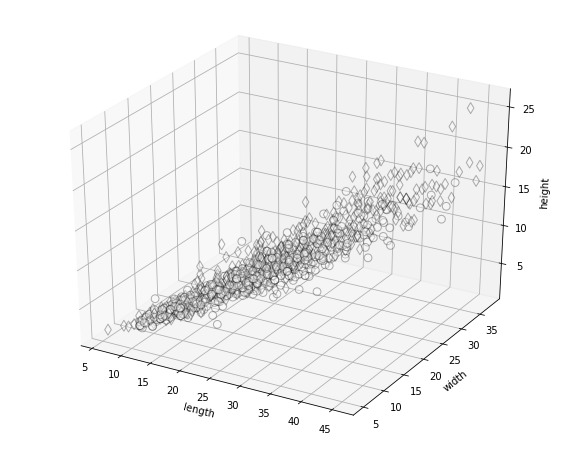

In [4]:
fig = MPP.figure(figsize = (10,8))
ax = fig.gca(projection='3d')


trafo = lambda vec: vec
# trafo = lambda vec: NP.log(vec)

for species in NP.unique(data['species'].values):
    for microhab in NP.unique(data['habitat'].values):
        rowfilter = NP.logical_and(data['species'] == species \
                                    , data['habitat'] == microhab)
        
        x_val,y_val,z_val = zip(*data.loc[rowfilter,['length','width','height']].values)
        
        ax.scatter( \
                      x_val, y_val, z_val \
                    , s = 60 \
                    , marker = symbols[species] \
                    , edgecolor = (0,0,0) \
                    , facecolor = 'w' \
                    , label = labels[species] + ", " + microhab \
                    , alpha = 0.3 \
                    )
ax.set_xlabel('length')
ax.set_ylabel('width')
ax.set_zlabel('height')
MPP.show()


The elongation of the point cloud indicates a high correlation within the three measurements. 
This means that there is one predominant axis of variation, related to ontogenetic growth of the limpets. 

Let's do a [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis?target=_blank) of that data. PCA is a simple mathematical operation if you understand the geometric intuition behind it [(as explained by Norm MacLeod here)](https://www.palass.org/publications/newsletter/palaeomath-101/palaeomath-part-5-pca-eigenanalysis-regression-v?target=_blank). This technique has many limitations, and several variants exist. We'll do it anyways, and use our own implementation to understand what's going on.

In [5]:
### pca
dat_matrix = data.loc[:,['length','width','height']].values
raw_mean = NP.mean(dat_matrix, axis = 0)

# first, we center the data around the mean.
dat_matrix -= raw_mean

# eigenanalysis
eigenvalues, eigenvectors = LA.eig(NP.cov(dat_matrix, rowvar = False, ddof = 1))
weights = eigenvalues / NP.sum(eigenvalues)

# sort eigenvectors
eigenvectors = NP.stack([eigenvectors[:,j] for (i,j) \
                             in sorted(zip(list(-NP.real(eigenvalues)) \
                                           ,range(eigenvectors.shape[1])))])

# eigenvectors are the columns of this matrix: 

print(eigenvectors)

eigenvectors[0,:] *= -1 # flip PC1 to make bigger samples appear on high values

# transform data
dat_trafo = dat_matrix.dot( eigenvectors.T )


data['PC1'] =  dat_trafo[:,0]
data['PC2'] =  dat_trafo[:,1]

ReTraFo = lambda pc_scores: NP.dot(pc_scores, eigenvectors[:2,]) + raw_mean


[[-0.7264248  -0.60065377 -0.33394917]
 [-0.20493818 -0.27448826  0.93949802]
 [-0.65597816  0.7509136   0.07629819]]


Let's plot the PCA space with shape models to see what the axes mean.

In [6]:
# get the means per species

aggregation = {'mean': NP.mean, 'sem': lambda x: NP.std(x, ddof = 1)/NP.sqrt(len(x)-1)}
species_means = data.groupby(['species']).agg({'PC1': aggregation, 'PC2': aggregation}).reset_index()

species_means

/usr/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


species   PC1         PC2      
             mean   sem  mean   sem
0  depressa -1.07  0.40 -0.58  0.06
1   vulgata  1.07  0.51  0.58  0.07

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:86: ComplexWarning: Casting complex values to real discards the imaginary part


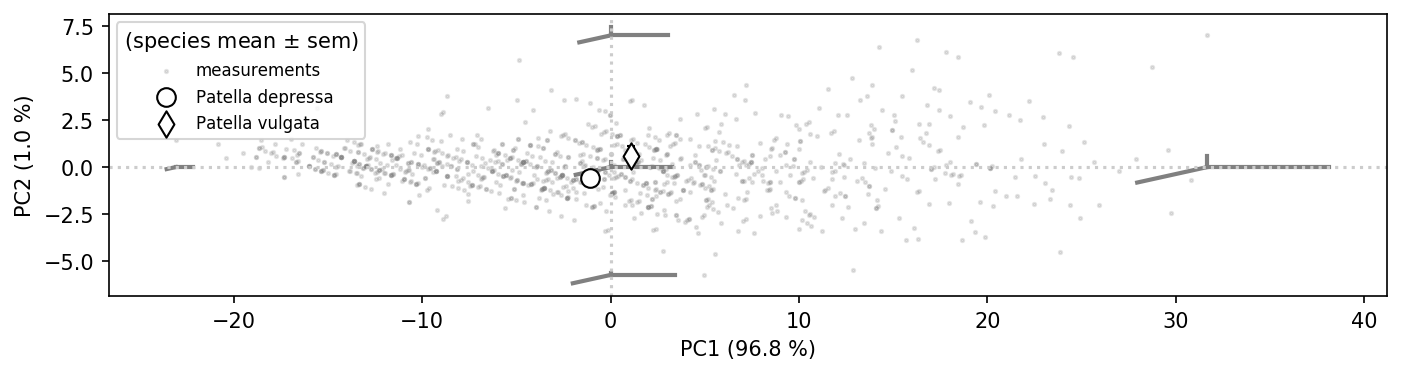

In [7]:
fig = MPP.figure(figsize = (24/2.54, 18/2.54), dpi = 150)
ax = fig.add_subplot(1,1,1, aspect = 'equal')


# if False:
ax.scatter( \
          data['PC1'] \
        , data['PC2'] \
        , s = 10 \
        , marker = '.' \
        , edgecolor = '0.5' \
        , facecolor = '0.5' \
        , zorder = -1 \
        , alpha = 0.2 \
        , label = 'measurements' \
    )


for s in species_means.index:
    ax.scatter( \
              species_means['PC1']['mean'].values[s] \
            , species_means['PC2']['mean'].values[s] \
            , s = 80 \
            , marker = symbols[species_means['species'].values[s]] \
            , edgecolor = (0,0,0) \
            , facecolor = 'w' \
            , zorder = 10 \
            , label = labels[species_means['species'].values[s]] \
        )

    ax.errorbar( \
              species_means['PC1']['mean'].values[s] \
            , species_means['PC2']['mean'].values[s] \
            , species_means['PC1']['sem'].values[s] \
            , species_means['PC2']['sem'].values[s] \
            , capsize = 2 \
            , ls = '-' \
            , color = 'black' \
            , elinewidth=1 \
            , zorder = 0 \
            )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
MPP.legend(loc = 2, title = r'(species mean $\pm$ sem)', fontsize = 8)
MPP.tight_layout()



means = NP.round(NP.mean(data.loc[:, ['PC1', 'PC2']], axis = 0), decimals = 6)

for pc in [1,2]:
    min_val = NP.min(data['PC%i' % (pc)])
    max_val = NP.max(data['PC%i' % (pc)])

    lower = means.copy()
    lower[pc-1] = min_val

    upper = means.copy()
    upper[pc-1] = max_val

    for point in [lower, upper, NP.zeros(2)]:
        if ((pc != 1) and (NP.sum(NP.abs(point)) == 0)):
            continue

        retrafo = ReTraFo(point)[:]

        scale = 0.2 / NP.max(NP.abs(data['length']))
        scale_axis = NP.array((NP.max(NP.abs(data['PC1'])), NP.max(NP.abs(data['PC2']))))

        vectors = [[1,0], [-1/NP.sqrt(2),-1/NP.sqrt(2)], [0,1]]
        vectors = NP.array(vectors)

        for aspect in range(3):
            target = point + scale * scale_axis * vectors[aspect,:] * retrafo[aspect]
            ax.plot( \
                      [point[0], target[0]] \
                    , [point[1], target[1]] \
                    , ls = '-' \
                    , color = '0.5' \
                    , lw = 2 \
                    , label = 'shape models at extremes' if ((pc == 1) and (NP.sum(NP.abs(point)) == 0) and (aspect == 0)) else None \
                    )


ax.set_xlabel(r'PC1 (%.1f %%)' % (100*weights[0]))
ax.set_ylabel(r'PC2 (%.1f %%)' % (100*weights[1]))
ax.axhline(0, color = '0.8', ls = ':')
ax.axvline(0, color = '0.8', ls = ':')

MPP.show()

This plot shows a slice through the "morphometry space" of limpets, as extracted from individual observations (grey dots) and shape models (grey lines). Species means are indicated by the bigger symbols. 

As can be seen, the PCA captured what we guessed from the point cloud. The main axis of variation is one that covers growth of the animals. The growth is isometric, i.e. all dimensions seem to grow alike. 

Along PC2, animals are of the same ground area, but flattened (reduced height) at lower PC2 values.

Now one could have some interesting hypotheses on the data. For example, the name "depressa" hints at a flatter shell. And indeed, _P. depressa_ seems to have a lower average PC2 value. 

Yet how much lower is it? Is it consistently lower, i.e. are species distinguishable by a height ratio? The scatter plots above do not seem like this feature is diagnostic.

**Hypothesis $H_0$: _Patella depressa_ has a lower height ratio than _Patella vulgata_.**


Secondly, _P. vulgata_ specimens seem to be larger than _P. depressa_, which manifests in a higher average PC1.

**Hypothesis $G_0$: _Patella vulgata_ are larger than _Patella depressa_, i.e. have a higher PC1 value.**




Let's plot this ("naïvely").


First, we will calculate the derived parameters.

In [8]:
data['root_area'] = NP.sqrt(NP.sum(NP.power(data.loc[:, ['length', 'width']].values, 2), axis = 1))
data['height_ratio'] = NP.divide(data['height'].values, data['root_area'].values)
data['log_height_ratio'] = NP.log(data['height_ratio'].values)



Now, let's see how they correlate, in a cross correlation plot, and how they distribute per habitat.

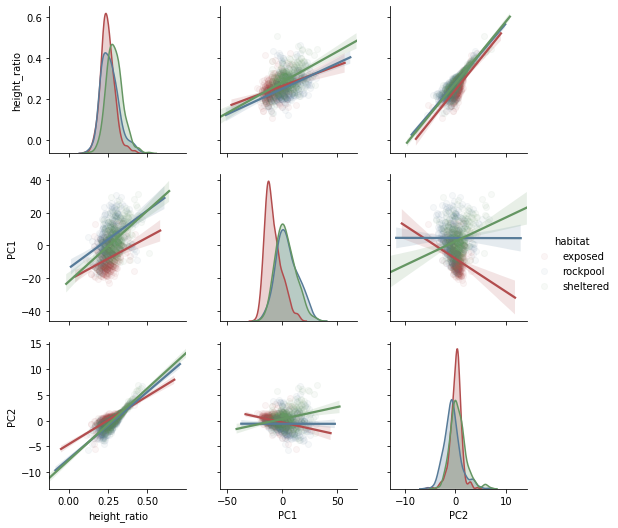

In [9]:
SB.pairplot(data.loc[:, ['habitat', 'species', 'height_ratio', 'PC1', 'PC2' ]], hue='habitat' \
                , kind='reg' \
                , markers='o' \
                #, palette={'exposed': 'darkblue', 'sheltered': 'darkgreen', 'rockpool': 'darkred'} \
                , palette=SB.color_palette("Set1", n_colors=3, desat=.5)
                , plot_kws=dict(scatter_kws = {'alpha': 0.05}) \
           );

... I would call this a "lightsabre plot".

## Digression: Assessing Normality

Let's briefly handle how one can test whether data is normally distributed. We will use the height ratio.
[(reference)](https://allendowney.blogspot.com/2013/08/are-my-data-normal.html?target=_blank)

Height ratio is not following a normal distribution, but a logarithmic transformation might help to establish this favorable statistic property. We'll find out.

In [10]:
values = data['height_ratio'].values
log_values = data['log_height_ratio'].values

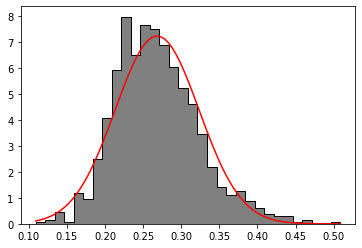

In [11]:
# plot the raw data
MPP.hist(values, bins = 32, histtype = 'stepfilled', density = True, color = '0.5', edgecolor = '0.');

# fit a normal distribution
mu, sd = STATS.norm.fit(values) 

# plot tha normal distribution
x = NP.linspace(NP.min(values), NP.max(values), 101, endpoint = True)
y = STATS.norm(mu, sd).pdf(x)
MPP.plot(x, y, ls = '-', color = 'r')
MPP.show();

Okay, `Normal` could do. Or better not. From low to high values, the bars are first above and then beolw the fit. So there is a kind of skew. Also, the tails are not symmetrical.

So let's hunt for a better match!


Because we want to test many different distributions, and also different variables, let's define a *function*.

**General advice:** Functions are your friend. Use as many as possible. Break down your code into little tasks and reuse these as often as you can. 

In [12]:
def DistributionFitPlot(values, DistributionFunction, label, ax = None, *args, **kwargs):
    
    # if no axis was given, make one
    if ax is None: 
        fig = MPP.figure(dpi = 150, figsize = (3, 2))
        ax = fig.add_subplot(1,1,1)
        
    # fit a given distribution function.
    fit_parameters = DistributionFunction.fit(values) 

    # plot a histogram and extract center points
    heights, bins, _ = ax.hist(  values, bins = 'fd' \
                               , histtype = 'stepfilled', density = True \
                               , color = '0.5', edgecolor = '0.' \
                               , zorder = 0);
    centers = NP.mean(NP.stack([bins[:-1],bins[1:]], axis = 1), axis = 1)

    # fit the distribution function to the data
    y = DistributionFunction(*fit_parameters).pdf(centers)

    # calculate the difference measure
    residual = NP.mean(NP.abs(NP.subtract(y,heights)))

    # plot the fit
    ax.plot(centers, y \
            , label = "%s (%.2e)" % ( label, residual ) \
            , *args, **kwargs \
           )
    
    # add a legend
    ax.legend(loc = 'best', fontsize = 8)
    
    # return stuff that might be used later on.
    return residual, fit_parameters, ax

You might ask: "Which distribution functions can I use?"
Check here: 
[scipy continuous distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions?target=_blank)


/usr/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


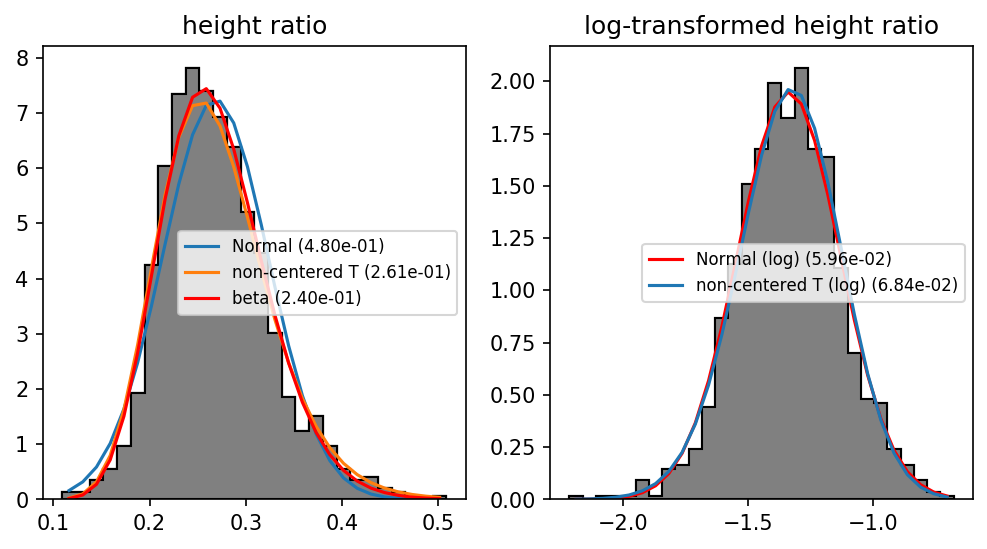

In [13]:
fig = MPP.figure(dpi = 150, figsize = (8, 4))

ax = fig.add_subplot(1,2,1)
DistributionFitPlot( values, STATS.norm, 'Normal', ax)
DistributionFitPlot( values, STATS.nct, 'non-centered T', ax)
_, fit_beta, _ = DistributionFitPlot( values, STATS.beta, 'beta', ax , color = 'r')
ax.set_title('height ratio')

ax = fig.add_subplot(1,2,2)
DistributionFitPlot( log_values, STATS.norm, 'Normal (log)', ax, color = 'r')
DistributionFitPlot( log_values, STATS.nct, 'non-centered T (log)', ax)
ax.set_title('log-transformed height ratio')


MPP.show();

Nice! The logarithmized data is well approximated by a normal distribution. 

In fact, the raw data is bounded to the [0, 1] interval\*, so **beta should be preferred**; but because we are far from the bounding value, it is okay to *assume normal distribution* for `log_height_ratio` values in our models.

\* I assume that if a limpet were higher than wide, it would fall to the side and be a well-dimensioned limpet again.

Alternative procedure: Quantile-Quantile plots (QQ Plots)

[probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html?target=_blank)


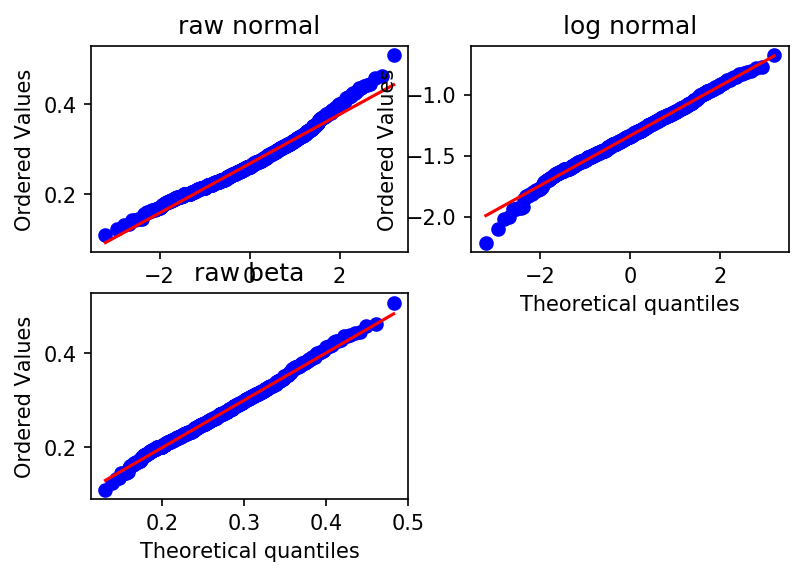

In [14]:

fig = MPP.figure(dpi = 150)
ax1 = fig.add_subplot(2,2,1)#,aspect = 'equal')
STATS.probplot(values, dist="norm", plot = ax1)
ax1.set_title('raw normal')

ax2 = fig.add_subplot(2,2,3)#,aspect = 'equal')
STATS.probplot(values, sparams = fit_beta, dist="beta", plot = ax2)
ax2.set_title('raw beta')

ax3 = fig.add_subplot(2,2,2)#,aspect = 'equal')
STATS.probplot(log_values, dist="norm", plot = ax3)
ax3.set_title('log normal')


MPP.show();

I would say `Beta` is the better approximation, but this only matters for a few particularly flat limpets (close to the lower boundary). Log normal will do.

## Categorical Comparisons

Making simple box plots (never the best solution, but a bad start).

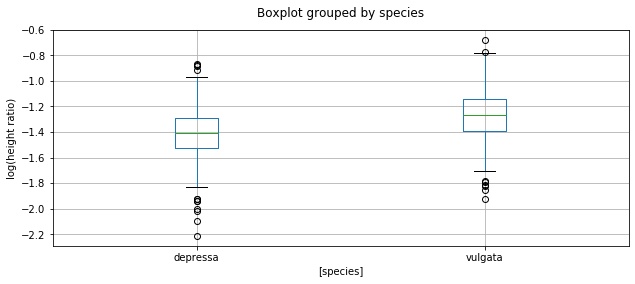

In [15]:
fig = MPP.Figure(figsize = (16/2.54, 8/2.54), dpi = 150)
data.boxplot(column = ['log_height_ratio'], by = ['species'], figsize = (10,4))
MPP.gca().set_title('')
MPP.gca().set_ylabel('log(height ratio)')
MPP.show();

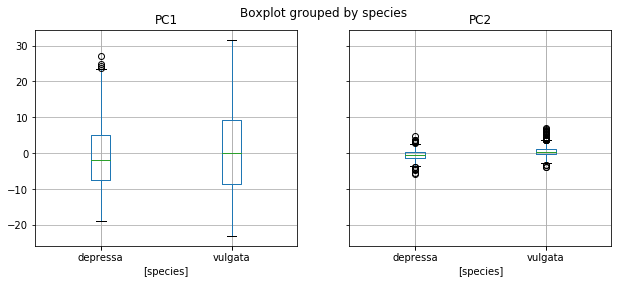

In [16]:
fig = MPP.Figure(figsize = (16/2.54, 8/2.54), dpi = 150)
data.boxplot(column = ['PC1', 'PC2'], by = ['species'], figsize = (10,4))
#MPP.gca().set_title('')
#MPP.gca().set_ylabel('PC1')
MPP.show();

Let's do what people have been doing conventionally: hypothesis tests of our hypotheses. 

In [17]:
species_idx = NP.array(data['species'].cat.codes, dtype = bool)
species_labels = {bool(nr): spec for nr, spec in enumerate(data['species'].cat.categories.values)}
print ('The order in which species are compared:', species_labels)

ks_stat, p_value = STATS.ks_2samp(  data.loc[species_idx, 'height_ratio'].values \
                   , data.loc[NP.logical_not(species_idx), 'height_ratio'].values \
                                 )

print ("height ratio: p = %.2e, ks statistic %.4f" % (p_value, ks_stat))

# and here we go, a T test (for whoever likes it)
t_stat, p_value = STATS.ttest_ind(  data.loc[species_idx, 'height_ratio'].values \
                   , data.loc[NP.logical_not(species_idx), 'height_ratio'].values \
                                 )

print ("height ratio: p = %.2e, t-statistic %.4f" % (p_value, t_stat))


# the same for PC1
t_stat, p_value = STATS.ttest_ind(  data.loc[species_idx, 'PC1'].values \
                   , data.loc[NP.logical_not(species_idx), 'PC1'].values \
                                 )

print ("PC1: p = %.2e, t-statistic %.4f" % (p_value, t_stat))

#... and PC2
t_stat, p_value = STATS.ttest_ind(  data.loc[species_idx, 'PC2'].values \
                   , data.loc[NP.logical_not(species_idx), 'PC2'].values \
                                 )

print ("PC2: p = %.2e, t-statistic %.4f" % (p_value, t_stat))

The order in which species are compared: {False: 'depressa', True: 'vulgata'}
height ratio: p = 9.99e-16, ks statistic 0.3223
height ratio: p = 7.97e-32, t-statistic 12.1504
PC1: p = 9.81e-04, t-statistic 3.3056
PC2: p = 1.71e-34, t-statistic 12.7159


**Lovely. Everything is as predicted,** the difference in height ratio is clearly significant, and it will be hard to reject the size difference.

Or is there a grain of salt we overlooked?
We did not rigorously check normality, and clearly have a problem with the immense sample size [(read up here)](https://allendowney.blogspot.com/2013/08/are-my-data-normal.html?target=_blank). And most importantly, we did not consider all information, for example where these limpets were found.

## The Influence of Multiple Parameters

The problem here is that there are multiple parameters that need to be taken into account. One of them is the species (*depressa* or *vulgata*, gladly these are just two in our case). But, there are also the micro-habitat (exposed, sheltered, rockpool) and the collection site.

As you will see, habitat and species are classical categorical parameters, also called "fixed effects" (though nothing about them is fix). Collection site is a "random effect" (though it is not particularly random at all). 

**It is advisible to forget about the terms "fixed" and "random"**. They are not useful (*cf.* [Gelman, 2013, "Bayesian Data Analysis"](http://www.stat.columbia.edu/~gelman/book/?target=_blank)). 
Instead, it makes sense to think of a **hierarchy of variability levels**. I will briefly explain in the following what this is supposed to mean.

All limpets in the world are a **population**. So taking together all measures we have, without distinguishing for habitat, will allow us to infer about the average size of a limpet. 

From this population, one can select subsets, for example categorizing by species or by collection site. 
The problem is that these categories overlap, and it is hard to separate the effects of each of the potentially diagnostic parameters. Don't worry. The model will do that for us. 

Splitting the population for species is like taking the distribution of all limpets and drawing (non-random) samples from it. These samples again form a distribution. 

Likewise, collecting at different areas of the beach (collection site) is drawing samples from the population distribution, each one forming a **subset distribution**. Conversely, collecting and adding all subset information will effectively be a sample from the whole population.

A third, commonly observed example are repeated measures of a few experimental subject animals. Together, they form a population (ideally being a random sample fromm all their conspecifics), and individual measurements are variable around a subject mean.

It should become clear that these and other are **multi-level situations**. It is possible that there are more than two hierarchical levels. Our questions and hypotheses above targeted species, and interpreting the other parameters as compounded influences. However, remember that technically, all of the categoricals are equal.













<img src="images/hierarchical_patella.svg" width="1108" height="778">

Note that I lend this type of illustration from this publication:
- Iknayan, K. J., Tingley, M. W., Furnas, B. J., and Beissinger, S. R. (2014).
    *Detecting diversity: emerging methods to estimate species diversity.*
    Trends in ecology & evolution, 29(2):97–106.


It is always a good strategy to compare the categories in the data and understand what is going on.

In [18]:
colors = {'exposed': (0.2,0.2,0.6), 'sheltered': (0.2,0.6,0.2), 'rockpool': (0.6,0.2,0.2)}

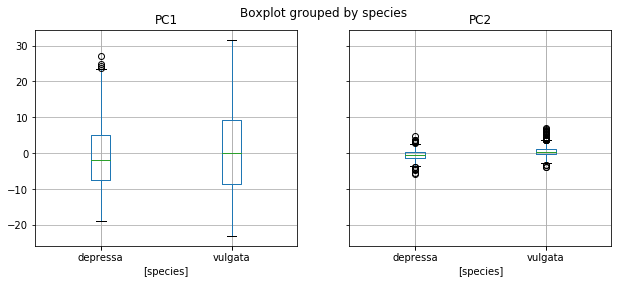

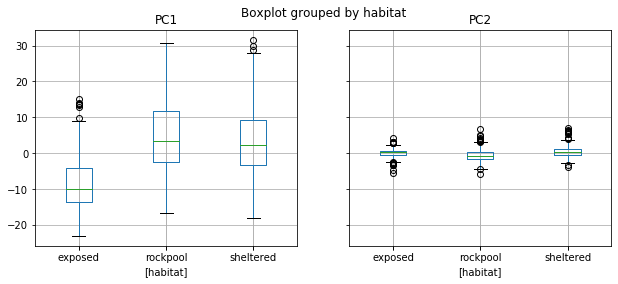

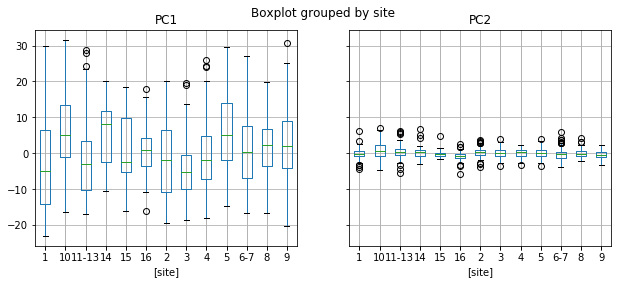

In [19]:

fig = MPP.Figure(figsize = (16/2.54, 8/2.54), dpi = 150)
data.boxplot(column = ['PC1','PC2'], by = ['species'], figsize = (10,4))
data.boxplot(column = ['PC1','PC2'], by = ['habitat'], figsize = (10,4))
data.boxplot(column = ['PC1','PC2'], by = ['site'], figsize = (10,4))
MPP.show()

#RoundMean = lambda x: NP.round(NP.mean(x),1)
#data.groupby(['species','habitat']).agg({'nr':{'count':len}, 'length': RoundMean, 'width': RoundMean, 'height': RoundMean})

## Example: PC1

We will focus on one variable, PC1, to find out about hypothesis $G_o$.

In [20]:
observable = 'PC1'

Again, we can check classical statistics to explore what effects might be interesting...

In [21]:

vulgatas = data['species'] == 'vulgata'
STATS.ttest_ind(  a = data.loc[vulgatas, observable].values \
                , b = data.loc[NP.logical_not(vulgatas), observable].values \
                , equal_var = True \
                )

Ttest_indResult(statistic=3.3056469225591427, pvalue=0.0009805572311505008)

... however, this simple version of hypothesis tests is blind to the overlap of influential effects.

<hr>

# Model Design <a class="anchor" id="design"></a> 
([^](#toc) top) 

Most of the models out there are linear. This is due to favorable attributes of linear models, most importantly that they can be applied to categorical parameters. Also, quite many non-linear settings can be transformed in mathematically elegant ways to map into a linear space.

In mathematical terms, a linear model can be described by the following equation. Therein, $\alpha$ is an intercept, $\beta$ a slope, $\epsilon$ the residual (measurement uncertainty, noise, etc.) and $y$ are the observations.

$\mathbf{y = \alpha + X\beta + \epsilon}$

<br>or, explicitly splitting the parameter matrix into vectors:

<img src="images/glm_formula.svg" width="358" height="56">

<br>For example, $x_i$ can be boolean arrays (if data is categorical).

$ \begin{align} length 
&= intercept &+ \left( species==vulgata\right) &\cdot \beta_1 &+  \left( habitat==exposed\right) &\cdot \beta_2 &+ residual
\\\left( \begin{array}{c}19.8\\23.4\\17.5\\\ldots\end{array} \right) &= 20.0 &- \left( \begin{array}{c}0\\1\\1\\\ldots\end{array} \right) &\cdot 2.1 &+ \left( \begin{array}{c}0\\1\\0\\\ldots\end{array} \right) &\cdot 4.9
&+ \left( \begin{array}{c}-0.2\\0.6\\-0.4\\\ldots\end{array}\right)
\end{align}
$

This is a simple regression problem: **fit $\beta$, minimize $\epsilon$!**

Depending on your favorite statistics software, this can be implemented using "formula" notation. 

First, I will explore the Frequentist way of modeling, [using `statsmodels`](https://www.statsmodels.org/devel/examples/notebooks/generated/mixed_lm_example.html).

This way is quick and good, but I sometimes find it limited (discussion below). Here is a simple example, describing the value of PC1 as a combination of an intercept (baseline value) and slopes for species and habitat.

In [22]:
# http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/glm_formula.html

formula = '%s ~ species + habitat' % (observable)

species_statsmodel = SMF.glm(formula=formula, data=data, family=SM.families.Gaussian()).fit()
species_confidence = species_statsmodel.conf_int()
# print (species_confidence)
print(species_statsmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PC1   No. Observations:                 1023
Model:                            GLM   Df Residuals:                     1019
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          76.228
Method:                          IRLS   Log-Likelihood:                -3666.3
Date:                Fri, 27 Sep 2019   Deviance:                       77676.
Time:                        20:43:59   Pearson chi2:                 7.77e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -8.5896 

**What does all that mean?**

Just like in the formulas above, you get
- an intercept
- slopes
- ... but also a p-value (usually likelihood ratio tests) and confidence intervals.


Make sure you can recover all of these in the results table above!



The species slope still seems to be just close to significance, but the picture is less clear than with the significance test above. 

Note that `habitat` has been split: because it is categorical, and not continuous, there will be one slope for each habitat ('rockpool', 'sheltered'). But wait. Really each habitat? Where is 'exposed'?! Right, it is the baseline, i.e. the value that limpets would have at the intercept. Why?

Try to think about such models as a mixture of linear functions ($observable = intercept + slope \cdot modulator$), in combination with boolean categories. The computer internally represents the exposed *P. depressa* as the zero value of these character axes, and groups the respective measurements there. Moving to `species == vulgata` will capture the change along the species axis (without changing habitat), to the category value of one. The remaining habitats are independent axes. Slopes are independent, thus opening a multidimensional space. The slope outcome is just the difference between the category-grouped means of the sampled values. 

I know this is quite abstract, but try to develop your own intuition for what is going on here.



<img src="images/multidim.png" width="800" height="396">


So we have seen that the effect of species is less pronounced when we add a model component for habitat.
What about the site? We have generously left it out for the simple model.



## Adding a Second Level: Multi-Level Intercept

The term "multi-level models" is in certain regards similar to "Generalized Linear Models" (GLMs) and "Hierarchical Models". A great tutorial can be found [here](https://docs.pymc.io/notebooks/GLM-hierarchical.html?target=_blank).

They are used to somehow reflect the structure in the data, as indicated above. 
We will explore how to apply them to our data set.

First, one more glance at the data.

/usr/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


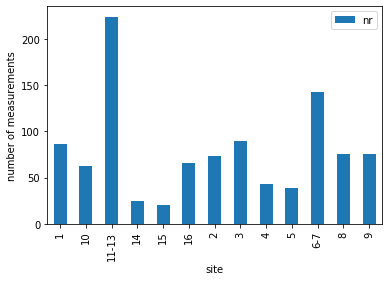

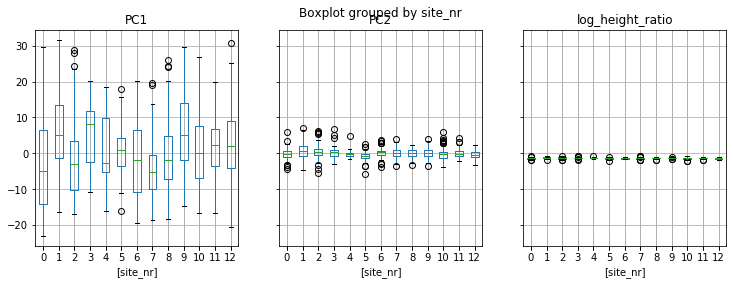

In [23]:
# we need to make a vector that contains the site information
site_lookup = {cat: nr for nr, cat in enumerate(sorted(NP.unique(data['site'])))}
data['site_nr'] = [site_lookup[site] for site in data['site']]
location_names = data['site_nr'].unique()
location_idx = data['site_nr'].values
n_locations = len(location_names)
    

# plot animals per site
data.loc[:,['site','nr']].groupby(['site']).agg( len ).plot(kind = 'bar')
MPP.gca().set_ylabel('number of measurements')

# plot average values per site
data.boxplot(column = ['PC1','PC2','log_height_ratio'], by = ['site_nr'], figsize = (12,4), layout = (1,3));


The student scientists sampled 13 sites (some were spatially clustered and grouped, so the original site labels are not continuous integers).
<br> What if the resulting values differ at each site? Are the sites really homogeneous? For example, what if one pool gets more inflow of nutrients than another, and for some reason only *depressa* settled there?

Such considerations require multi-level models. As in our example, multiple levels should be used if they make sense with the structure of the data (which will, besides considerations of simple logic, be tested by model comparison, see below). Levels should neither be justified by common habit of others in the field, nor by personal taste. They need to be reasonable and reproducible.

We will next define what is called a "random intercept model", or more appropriately, we'll assume that the site-level distributions of sub-populations are parallelly shifted from a variable baseline value. This implies that we expect the __difference__ among species and among habitats to be equal at all collection sites.

In [24]:
# the random intercept is added by putting a "1+site" summand in the formula.
formula = '%s ~ species + habitat + (1+site)' % (observable)

multilevel_statsmodel = SMF.glm(formula=formula, data=data, family=SM.families.Gaussian()).fit()
ml_confidence = multilevel_statsmodel.conf_int()
#print (ml_confidence)
print(multilevel_statsmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PC1   No. Observations:                 1023
Model:                            GLM   Df Residuals:                     1007
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                          67.899
Method:                          IRLS   Log-Likelihood:                -3601.0
Date:                Fri, 27 Sep 2019   Deviance:                       68374.
Time:                        20:44:00   Pearson chi2:                 6.84e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -10.1183 

This again shows intercept and slopes of linear models.

Let's compare the outcomes of the single- and multi-level construction:


In [25]:
multilevel_dataframe = multilevel_statsmodel.params.to_frame()

comparison = species_statsmodel.params.to_frame().join(multilevel_dataframe, how = 'left', rsuffix = '_multilevel')
comparison

0  0_multilevel
Intercept             -8.59        -10.12
species[T.vulgata]     1.01          0.58
habitat[T.rockpool]   12.77         14.32
habitat[T.sheltered]  11.17         11.31

 
The intercept has clearly changed, because the `site[]` slopes are added to it. Here are the slopes at the individual sites:   

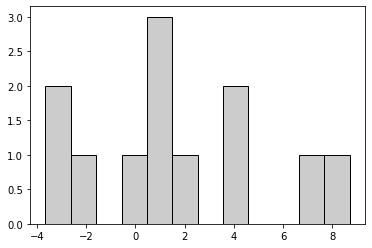

In [26]:
site_intercepts = multilevel_dataframe.loc[[idx for idx in multilevel_dataframe.index if 'site' in idx], :].values

MPP.hist(site_intercepts, bins = 12, facecolor = '0.8', edgecolor = 'k');

Hence, the intercept is now split between a common intercept that approximates the average of the entire population, and an additional sub-population summand that for some sites is much bigger than zero. Together, these two match approximately the outcome of the single-level model.  

**model verdict:**

The introduction of a multi-level intercept has cleared the case of the `species` slope: the effect is not significant. The reason we saw a difference in the simple models is that there is a strong size increase in rockpools and sheltered habitats, and that species and maybe age groups are not evenly distributed across micro-habitats and sites. 

<hr>

# StatsModels Generalization: Object Oriented Programming <a class="anchor" id="oop"></a> 
([^](#toc) top) 

So this was PC1. We'll now get an overview of all the observables, using a similar model as before.

In [27]:
# common variables needed below:
result_parameters = ['Intercept', 'species[T.vulgata]', 'habitat[T.rockpool]', 'habitat[T.sheltered]']

I tend to wrap repetitive tasks into objects and functions. Let's make a `StatsModel` *object*.

The term *object* refers to *object-oriented programming*, a concept that is common to most modern programming languages. In python, we define a `class`, which is like a blueprint for the objects of a similar kind. A class is abstract, and holds all the features (variables) and abilities (functions) common to the objects. But a class does not generally store values for these variables, nor does it execute the functions (there are exceptions, of course). This is done later on, in the objects which are initialized according to the class structure. Classes/objects and functions provide very useful building blocks, which can greatly help to retain an overview if code scales.

Translated to our case: we will define an abstract model object. This will cover some basic functionality common to all models, for example printing the results. Then, we create different models from different model formulae, all of which can use the arsenal of functions from their class.

In [28]:
class StatsModel(object):
    def __init__(self, data, observable, formula = '1', show_result = False):
        self.formula = r'%s ~ %s' % (observable, formula)
                
        self.result = SMF.glm(formula=self.formula, data=data, family=SM.families.Gaussian()).fit()
        
        if show_result:
            self.DisplaySummary()
        
    def GetResults(self, result_parameters):
        #print(dir(self.result.params))
        #print(self.result.params.to_frame())
        df = self.result.params.to_frame()
        conf = self.GetConfidence()
        conf.columns = ['low', 'high']
        df.columns = ['mean']
        df = df.join(conf, how = 'left')
        df['significance'] = self.GetSignificance()
        
        return df.loc[result_parameters, :]
    
    def GetConfidence(self, *args, **kwargs):
        return self.result.conf_int(*args, **kwargs)
    
    def GetSignificance(self):
        return NP.abs(NP.diff(NP.sign(self.GetConfidence()), axis = 1))==0
    
    
    def DisplaySummary(self):
        print(self.result.summary())

Now check if we programmed everything right, by repeating the results from above:

In [29]:
simple = StatsModel(data, observable, 'species + habitat', show_result = False)
print(simple.GetResults(result_parameters))

                       mean    low   high  significance
Intercept             -8.59  -9.63  -7.54          True
species[T.vulgata]     1.01  -0.10   2.11         False
habitat[T.rockpool]   12.77  11.44  14.10          True
habitat[T.sheltered]  11.17   9.83  12.51          True


And another model:

In [30]:
multilevel_intercept_model = StatsModel(data, observable, 'species + habitat + (1 + site)', show_result = False)
print(multilevel_intercept_model.GetResults(result_parameters))

                       mean    low   high  significance
Intercept            -10.12 -12.03  -8.21          True
species[T.vulgata]     0.58  -0.51   1.68         False
habitat[T.rockpool]   14.32  12.89  15.75          True
habitat[T.sheltered]  11.31  10.03  12.59          True


Just to get an overview, let's assume the multi-level model is the better one. 
Then, we iterate the observables ('height_ratio', 'PC1' and 'PC2') and see which parameters (species, habitat) are predictive.

In [31]:
all_observables = ['log_height_ratio', 'PC1', 'PC2']
frequentist_results = PD.DataFrame(columns = all_observables, index = result_parameters)

for obs in all_observables:
    model = StatsModel(data, obs, 'species + habitat + (1 + site)', show_result = False)
    result = model.GetResults(result_parameters)
    
    for param in result_parameters:
        frequentist_results.loc[param, obs] = "%.2f %s" % (result.loc[param, 'mean'], '*' if result.loc[param, 'significance'] else '')
        
        
frequentist_results

log_height_ratio       PC1      PC2
Intercept                     -1.54 *  -10.12 *  -0.73 *
species[T.vulgata]             0.12 *     0.58    1.06 *
habitat[T.rockpool]            0.05 *   14.32 *  -0.85 *
habitat[T.sheltered]           0.13 *   11.31 *    0.16

This object-oriented process takes a bit of work to get implemented, but it is much more powerful when it comes to comparing the many parameter settings that could be chosen. 

So this is what we expect to find in our data: 
- `height_ratio` is affected by all parameters, but maybe the "sheltered" one is a special habitat.
- `PC1` is strongly affected by habitat, and indifferent to species.
- `PC2` is species-dependent, and additionally rockpools seem to have an effect on it.



## Flexible Frameworks

As far as I understand it, statsmodels uses a frequentist way of regressing ("fitting") the model to the data, i.e. the model parameters are iteratively adjusted until they match the measurements.
This is usually done by Maximum Likelihood. 

Maximum Likelihood and hypothesis tests are nice, but limited (see [here](http://pymc-devs.github.io/pymc3/notebooks/BEST.html?target=_blank) for example). 


I am not a particular fan of formula notation, because it disguises what is going on in the model. 
Also, I did not find a way to model a multi-level slope in `statsmodels`, and I have not explored model comparison. Another desirable feature of models is *prediction*, for which `statsmodels` has some capability. I found these hard to access, which is why I have not been diving into this library in the past.  

The reason why I personally found this hard to access was that this and similar toolboxes are what I would call **keyword-driven**. By that I mean that, to apply a specific modification of a default model, one would have to know specific keywords. For example, to change the distribution `family` to something different from `Gaussian`, I would have to [scan](http://www.statsmodels.org/dev/index.html?target=_blank) [through](http://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html?target=_blank) [the](http://www.statsmodels.org/dev/glm.html#families?target=_blank) [documentation](http://www.statsmodels.org/dev/generated/statsmodels.genmod.families.family.Binomial.html?target=_blank). Because keywords are hardly ever consistent, I find myself searching over and over again, which I find unpleasant. The opposite would be **object-driven** statistical syntax. It is characterized by an assembly of basic components, which are `objects` and can be modified by themselves. This approach is more modular, and you will see an example in a bit. Of course, one still has to read documentation, but one can also get creative with very basic building blocks.

For me, `statsmodels` is a great tool for quick tests. It has the most relevant features that you would also find in the standard `R` packages (which is, by the way, also primarily keywoard-driven code). 
For more involved models, I prefer modular code constructs. Although that is more brain consuming on the implementation, they are more flexible.

This is not to be confused with the "Frequentist|Bayesian" dichotomy here. There are keyword- and object-driven implementations on both sides.


In the end, all these worlds should roughly match in outcome. Hence, it is good to calculate models in different systems and check whether they converge to the same result.


<hr>

# Probabilistic Modeling <a class="anchor" id="probabilistics"></a> 
([^](#toc) top) 

I will now demonstrate the probabilistic modeling process, slowly incrementing complexity. My framework of choice is [`pymc3`](https://docs.pymc.io?target=_blank).


To continue, we need a few preparations.

In [32]:
### some more lookup helpers

# first, the species is defined, with vulgata being the reference
species_map = {sp:nr for nr, sp in enumerate(data.species.unique())}
data['species_nr'] = [species_map[sp] for sp in data['species']]
species_change = r'species %s $\rightarrow$ %s' % ({v:k for k,v in species_map.items()}[0], {v:k for k,v in species_map.items()}[1])

# we will also require booleans for the habitat categories. "Exposed" is our baseline here.
data['habitat_is_rockpool'] = NP.array([cat == 'rockpool' for cat in data['habitat']], dtype = float)
data['habitat_is_sheltered'] = NP.array([cat == 'sheltered' for cat in data['habitat']], dtype = float)

rockpool_change = r'microhab exposed $\rightarrow$ rockpool'
sheltered_change = r'microhab exposed $\rightarrow$ sheltered'


# we also add some sugar to the plot function
def PlotTraces(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = PM.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      combined = True \
                      , lines={k: v['mean'] for k, v in
                             PM.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(PM.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

In [33]:

# for summary and plot:
show_variables = ['intercept', 'residual', 'dof' \
                , species_change \
                , rockpool_change \
                , sheltered_change \
                ]

# sampling parameter
sampler_steps = 2**10

With that, we can construct our linear model, first implementing a single, detailed example, and then generalizing that.


## Probabilistic Model Example

Now let's go step by step. We define a model first, but initially just declare a variable that we will later use to assemble the right hand side of our model equation.


In [34]:
with PM.Model() as multilevel_model:
    estimator = 0



Reasoning as before, we assume that our predicted variables have a baseline value (intercept). As we designed it, this is the value for *exposed* specimens of *P. vulgata*.  

Note that we will chose a multilevel intercept per default, knowing from above that this might be more appropriate and relevant for the outcome. This will confront us with the `shape` attribute in PyMC (see [here](https://lucianopaz.github.io/2019/08/19/pymc3-shape-handling/?target=_blank)).

In [35]:
with multilevel_model:

    # the population intercept mean and variance:
    population_intercept = PM.Normal('intercept', mu = 0., sd = 100)
    hypersigma_intercept = PM.HalfCauchy('hypersigma intercept', 5)

    # site-wise intercept:
    site_intercept = PM.Normal('site intercept', mu = population_intercept, sd = hypersigma_intercept, shape = n_locations)
    # note that the "shape" keyword is critical. It indicates that, instead of one Normal distribution, we get
    #    one for each site. They all have a mean that is sampled from the population intercept.

    # finally, we have to add the intercept to our estimator:
    estimator = estimator + site_intercept[location_idx]

        

To the intercept value, changes are added in observations where habitat or species is different. This happens by multiplying a conditional boolean with the specific slope, resembling the general model formulae introduced above.


In [36]:
with multilevel_model:
    # influence of habitat
    # see that we split this categorical, having one slope for each habitat as difference from a baseline habitat
    rockpool = PM.Normal(rockpool_change, mu=0, sd=100)
    shelter = PM.Normal(sheltered_change, mu=0, sd=100)

    # finally, add these to the estimator, as mentioned by multiplying with a boolean vector.
    estimator = estimator \
                + rockpool* data['habitat_is_rockpool'].values \
                + shelter * data['habitat_is_sheltered'].values



For `species`, we will go one step further than in the frequentist models: we can now check whether a slope is different for each site. This means we introduce a multilevel slope. This could also be done for the `habitat`, and likewise the `species` could be made single level. It is just for demonstration purposes, and all of these settings should be attempted in a real situation.

In [37]:
with multilevel_model:
    # influence of species
    population_species = PM.Normal(species_change, mu = 0., sd = 100)
    hypersigma_species = PM.HalfCauchy('hypersigma species', 5)
    # this is similar to the declaration of a multilevel intercept, which 
    #     makes sense: they are just different model components after all.
    site_species = PM.Normal('site species', mu = population_species, sd = hypersigma_species, shape = n_locations)

    # add species slope to the estimator, as mentioned by multiplying with a boolean vector.
    estimator = estimator \
                + site_species[location_idx] * data['species_nr'].values \

    

And, to round off, we need a model residual (uncertainty) and a posterior (left hand side). We will set the distribution of the posterior to be `StudentT` ([see here](https://docs.pymc.io/notebooks/GLM-robust.html?target=_blank)). 
This is a method for robust regression, but apart from that, the `nu` parameter (*degrees of freedom*, dof) allows us to test how "normal" the distribution of our posterior really is. When we leave `nu` to vary and be fitted with the model, a low resulting value will be indicative of "long tails", i.e. non-Normal distribution, i.e. outliers. In contrast, a high value of `nu` indicates that our observables are well approximated by a normal distribution.  

In [38]:
with multilevel_model:

    # model error
    residual = PM.HalfCauchy('residual', 5)

    # Student's T distribution "nu" parameter
    dof = PM.Gamma('dof', 5., 0.1 )
    
    # posterior, i.e. left hand side
    posterior = PM.StudentT(  'posterior' \
                            , mu = estimator \
                            , sd = residual \
                            , nu = dof \
                            , observed = data[observable].values \
                          )


Now that the model is in place, we have to perform MCMC sampling to estimate the distribution of priors from the observed data distributions.

In [39]:
multilevel_model.name = 'multi level intercept'

# now run sampler
with multilevel_model:
    multilevel_trace = PM.sample(sampler_steps, tune = sampler_steps, cores = 4, progressbar = True, target_accept = 0.999)    
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, site species, hypersigma species, species depressa $\rightarrow$ vulgata, microhab exposed $\rightarrow$ sheltered, microhab exposed $\rightarrow$ rockpool, site intercept, hypersigma intercept, intercept]
Sampling 4 chains: 100%|██████████| 8192/8192 [02:00<00:00, 67.94draws/s] 
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9806512197912073, but should be close to 0.999. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


There might have been some problems with the sampling here (number of effective samples, divergent samples), which I will  solve or discuss below. They have to do with the multilevel `species` slope, which was for demonstration purposes, so it is okay to ignore them for now (although it is generally not good to ignore warnings of this kind).


Compared to `statsmodels`, the sampling took a long time, which is typical for MCMC tools. However, the benefit is that one gets "Bayesian" estimates, i.e. probability distributions. Furthermore, probabilistic posterior sampling is possible to allow for the prediction of even unobserved outcomes. Also, as mentioned above, the implementation of the model might seem cumbersome, but it is much more flexible (as we saw with the multilevel slope), even allowing for non-linear components. The impedance by a long sampling duration is alleviated a bit if one models multiple observables at the same time: these can be sampled simultaneously, with only minor increase of duration.


The process only starts with sampling. One has to inspect the traces carefully to see whether the sampler has converged, whether the values are plausible, to extract the parameter posteriors of interest, and potentially to draw predictions from the model. I will just briefly check convergence, but recommend to read up on that and perform as many tests as are available, at least for the final model. 

In [40]:
# https://docs.pymc.io/api/stats.html
print ('#######\n statistics for reference model')
print ('bfmi:', PM.stats.bfmi(multilevel_trace))
print ('Gelman-Rubin statistic:')
print ({key: NP.max(val) for key, val in PM.diagnostics.gelman_rubin(multilevel_trace, varnames = show_variables).items()})


#######
 statistics for reference model
bfmi: 0.5528851090019145
Gelman-Rubin statistic:
{'intercept': 1.002105211340073, 'residual': 1.000335585940313, 'dof': 0.9996834359836745, 'species depressa $\\rightarrow$ vulgata': 1.0002890599319105, 'microhab exposed $\\rightarrow$ rockpool': 1.001545321328903, 'microhab exposed $\\rightarrow$ sheltered': 1.0008643530774222}


BFMI (look up the pymc3 documentation for more info) is not at its optimum, but Gelman-Rubin is good (which is due to the high `target_accept` set above).

Let's see the model outcome:

In [41]:

# summarize
multilevel_outcome = PM.summary(multilevel_trace, varnames = show_variables, combined = True).loc[:, ['hpd_2.5','mean','hpd_97.5']]
multilevel_outcome

/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


hpd_2.5   mean  hpd_97.5
intercept                                  -11.14  -8.58     -6.24
residual                                     7.61   8.01      8.41
dof                                         17.75  51.37     96.07
species depressa $\rightarrow$ vulgata      -0.82   0.97      2.96
microhab exposed $\rightarrow$ rockpool     12.62  14.10     15.55
microhab exposed $\rightarrow$ sheltered    10.06  11.31     12.56

The "credible interval" for the species slope includes zero, which again indicates that species has no decisive effect on PC1, i.e. that species cannot be distinguished by size alone.

Interestingly, the predicted mean of the intercept is closer to the single-level statsmodel from above, whereas the slopes better match the multilevel model. 

Degrees of freedom were estimated to be high (>10), so the distribution of PC1 values is quite close to Normal. 


Finally, a plot of the traces can be informative:

/usr/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


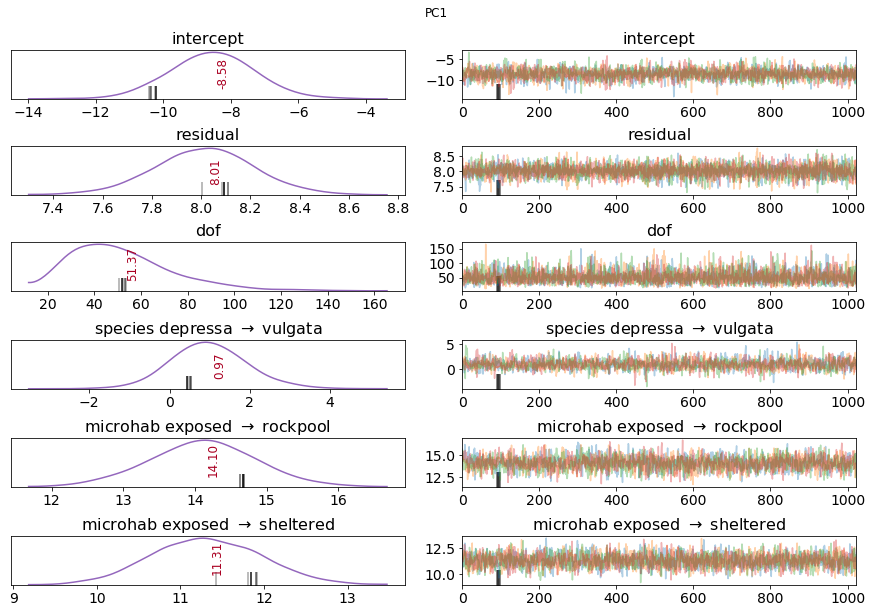

In [42]:
# plot results
PlotTraces(multilevel_trace, varnames = show_variables)
MPP.gcf().suptitle(observable.replace('_',' '))
MPP.show()


I've skipped over a lot of detail here, but these can be read up online, and they differ between softwares.
Instead, I've tried to highlight some general best practices (stepwise model construction, robust regression, posterior inspection).

But was the model we chose really optimal to fit the data? From those that are logically plausible, which settings are the "right" ones to choose? To find out, we will have to perform model comparison. But first, we will repeat the model construction and generalize it via object oriented programming.



**model verdict:**
We could reproduce the findings from above in a probabilistic framework. This is good, because the implications extracted from the data should be indifferent to the model implementation, given that the model structure is identical.
The probabilistic framework brings incredible flexibility, but that of course demands a lot of design choices. 

<hr>

# Generalized Probabilistic Model Construction <a class="anchor" id="oop_probabilistics"></a> 
([^](#toc) top) 

Such design choices can rarely be made *a priori*. Usually, the process is rather a long one of trial and error. Parameter combinatorics can complicate model selection, so one should put some effords in keeping track of the choices that produced a favorable or unfavorable outcome.

As with the `StatsModel` class above, I always strive to get modular code that facilitates the comparison of different model structures. Model comparison will follow below. It is, I would argue, the most relevant part of modeling, because it helps to distinguish the relevant effects from the irrelevant ones. For example, I have arbitrarily chosen to include a multilevel `species` slope above, but the sampler warnings question the validity of this choice. 


For Probabilistic Models, we need a model class, but I also like to have a "settings" object associated with it to enable storage of the settings that were chosen.

In [43]:
"""
#######################################################################
### Settings                                                        ###
#######################################################################
"""
class Settings(dict):
    """
    setting storage by subclassing dict
    with default settings
    from http://stackoverflow.com/a/9550596
    """
    
    def __init__(self, settings = None, basic_settings = None): 
        # first initialize all mandatory values.
        self.SetDefaults()

        # then overwrite everything by the basic settings.
        if basic_settings is not None:
            for key in basic_settings.keys():
                self[key] = basic_settings[key]

        # finally overwrite everything the user provides.
        if settings is not None:
            for key in settings.keys():
                self[key] = settings[key]


#    def __getattr__(self, param):
#        return self[param]
#
#    def __setattr__(self, param, value):
#        self[param] = value


    def SetDefaults(self):
        # set the default settings
        # should work for simulation and real data
        # set to be a quick test

        ### observables as list
        self['observables'          ] = []

        ### parameters which are single level
        self['plain_parameters'     ] = []
        # nesting method if hierarchical intercept
        self['multilevel_parameters'] = {} # dict of the structure "parameter: level"; for example "'intercept': 'site'"
        self['levels'] = []
        
        # prior settings
        self['distributions'] = {}
        self['kwargs'] = {}

        # model labels
        self['labels'] = {}

        ### posterior
        # use Normal (robust = False) or StudentT (robust = True) distribution
        self['robust'] = False

        # what to show
        # self['show'] = []

        

This is not more yet than an extended dictionary. But we will populate it for our *Patella* data further below.


A class that wraps up the model components will follow. Note that notebooks are not optimal for the demonstration of object oriented programming, because the class definition has to happen in one cell. Thus, you will now see a long block of code, which might be hard to overview. Nevertheless, the elegance of the repeated use of that code will become apparent later on.

In [44]:
"""
#######################################################################
### Probabilistic Model Class                                       ###
#######################################################################
"""
class Model(dict):
    def __init__(self, data, settings, verbose = True):
        self.data = data
        
        self.settings = settings
        
        self.n_observables = len(self.settings['observables'])
        if self.n_observables == 0:
            raise IOError('please specify observables.')
        
        
        self.shared = {}
        self.show = []
        self.labels = {}
        self.levels = {}
    
        self.model = PM.Model()
        self.estimator = 0
        
        self.verbose = verbose
            
    
        for level in set(self.settings['multilevel_parameters'].values()):
            
            self.settings['levels'].append(level)
            
            levels = list(sorted(NP.unique(self.data[level])))
            lookup = {cat: nr for nr, cat in enumerate(levels)}
            self.levels[level] = NP.array([lookup[site] for site in self.data[level]])
        # print (self.levels)
    
        self.ConstructModel()
        self.trace = None
    
    
    def ConstructModel(self):
        
        # single level model components
        for component in self.settings['plain_parameters']:
            if self.verbose:
                print ("adding population %s as %s" %(component, self.settings['labels'].get(component, component)))
            self.AppendPlainComponent(   data_column = component \
                                       , label = self.settings['labels'].get(component, component) \
                                       , distribution = self.settings['distributions'].get(component, None)
                                       , **self.settings['kwargs'].get(component, {}) \
                                          )

        # multilevel components
        for component, level in self.settings['multilevel_parameters'].items():    
            if self.verbose:
                print ("adding ml %s" %(component))

            self.AppendMultilevelComponent(data_column = component \
                                           , label = self.settings['labels'].get(component, component) \
                                           , level = level \
                                           , distribution = self.settings['distributions'].get(component, None) \
                                           , **self.settings['kwargs'].get(component, {}) \
                                          )
        # prior (sometimes called "likelihood")
        self.ConstructPosterior()
        
        
    def AppendMultilevelComponent(self, data_column, label, level, distribution = PM.Normal, *args, **kwargs):
        # store the label
        self.labels[label] = data_column
        # print ('\t', data_column, label, distribution)
        
        # default priors
        if 'mu' not in kwargs.keys():
            kwargs['mu'] = 0
        if 'sd' not in kwargs.keys():
            kwargs['sd'] = 100
        
        # default distribution
        if distribution is None:
            distribution = PM.Normal
        if self.verbose:
            print ('\t', distribution)
        
        
        # append the model
        with self.model:
            # get the vector of data
            # which is complicated by patsy:
            #   https://stackoverflow.com/questions/35944841/is-this-the-expected-behavior-of-patsy-when-building-a-design-matrix-of-a-two-le
            #   https://github.com/pydata/patsy/issues/80
            
            # patsy notation is useful for two reasons:
            # - the sampling is much quicker
            # - using a "shared" theano variable, the data can be adjusted for prediction later.
            data_copy = self.data.copy()
            if data_column in data_copy.columns:
                if str(data_copy[data_column].dtype) == 'category':
                    data_copy[data_column] = data_copy[data_column].cat.codes
            
            data_vector = NP.asarray( \
                                  PA.dmatrix( '1' if data_column == 'intercept' else '%s + 0' % (data_column) \
                                , data = data_copy \
                                , return_type = 'dataframe' \
                                ))
            self.shared[label] = TH.shared(data_vector)
            
            # prior distribution
            if self.verbose:
                print ('\t data:', (data_vector.shape[1], self.n_observables))
                
            # group matrix
            grpmatrix = NP.asarray( \
                                          PA.dmatrix( '0 + %s' % (level) \
                                        , data = data_copy \
                                        , return_type = 'dataframe' \
                                        ))
            # correction needed for slopes: group matrix needs to be weighted with the data value.
            grpmatrix = NP.multiply(grpmatrix, NP.concatenate([data_vector]*grpmatrix.shape[1], axis = 1))
            self.shared["%s_%slvl" % (label, level)] = TH.shared(grpmatrix) 
            
                
                
            population_mean = distribution(label, shape = (data_vector.shape[1], self.n_observables), *args, **kwargs)
            self.show.append(label)
            
            population_sigma = PM.HalfCauchy('hypersigma %s' % (label), 5, shape = (self.n_observables))
            
            level_distributions = distribution( "%s_%slvl" % (label, level) \
                                               , mu = population_mean \
                                               , sd = population_sigma \
                                               , shape = (grpmatrix.shape[1], self.n_observables) \
                                              )
            
            if self.verbose:
                print ('\t level:', (grpmatrix.shape[1], self.n_observables))
                
            
            #self.show.append("%s_%slvl" % (label, level))
            #print ("\t %s_%slvl" % (label, level))
            
            #level_deterministic = level_distributions * population_sigma

            
            
            
            # append the estimator
            self.estimator = self.estimator + TT.dot(self.shared["%s_%slvl" % (label, level)], level_distributions )
            

            
            
    def AppendPlainComponent(self, data_column, label, distribution = None, *args, **kwargs):
        # store the label
        self.labels[label] = data_column
        # print ('\t', data_column, label, distribution)
        
        # default priors
        if 'mu' not in kwargs.keys():
            kwargs['mu'] = 0
        if 'sd' not in kwargs.keys():
            kwargs['sd'] = 100
        
        # default distribution
        if distribution is None:
            distribution = PM.Normal
        if self.verbose:
            print ('\t', distribution)
        
        
        # append the model
        with self.model:
            # get the vector of data
            # which is complicated by patsy:
            #   https://stackoverflow.com/questions/35944841/is-this-the-expected-behavior-of-patsy-when-building-a-design-matrix-of-a-two-le
            #   https://github.com/pydata/patsy/issues/80
            
            # patsy notation is useful for two reasons:
            # - the sampling is much quicker
            # - using a "shared" theano variable, the data can be adjusted for prediction later.
            data_copy = self.data.copy()
            if data_column in data_copy.columns:
                if str(data_copy[data_column].dtype) == 'category':
                    data_copy[data_column] = data_copy[data_column].cat.codes
            #    print(data_copy[data_column])
            data_vector = NP.asarray( \
                                  PA.dmatrix( '1' if data_column == 'intercept' else '%s + 0' % (data_column) \
                                , data = data_copy \
                                , return_type = 'dataframe' \
                                ))
            # print(data_vector)
            # data_vector = data_copy.loc[:, [data_column]]
            self.shared[label] = TH.shared(data_vector) # theano shared tensors are used for prediction.

            # prior distribution
            if self.verbose:
                print ('\t', (data_vector.shape[1], self.n_observables))
            prior_distribution = distribution(label, shape = (data_vector.shape[1], self.n_observables), *args, **kwargs)

            # append the estimator
            self.estimator = self.estimator + TT.dot(self.shared[label], prior_distribution )
            self.show.append(label)
        
        
        
    def ConstructPosterior(self):
        # gather arguments
        posterior_kwargs = {}
        
        with self.model:
            # model error
            posterior_kwargs['sd'] = PM.HalfCauchy('residual', 5, shape = (1, self.n_observables))
            self.show.append('residual')

            # Student's T distribution "nu" parameter
            if self.settings['robust']:
                posterior_kwargs['nu'] = PM.Gamma('dof', 5., 0.1, shape = (1, self.n_observables) )
                self.show.append('dof')
                PosteriorDistribution = PM.StudentT
            else:
                PosteriorDistribution = PM.Normal



            # posterior, i.e. left hand side of the model equation
            if self.verbose:
                print ('posterior:', PosteriorDistribution)
            posterior = PosteriorDistribution(  'posterior' \
                                     , mu = self.estimator \
                                     , observed = self.data.loc[:, self.settings['observables']].values \
                                     , **posterior_kwargs \
                                  )

        model_name = self.settings.get('name', None)
        if model_name is not None:
            self.model.name = model_name
        
    
    def Sample(self, *args, **kwargs):
        # sampling process
        with self.model:
            self.trace = PM.sample(*args, **kwargs)    
    
    
    def TracePlot(self):
        # standard plotting
        if self.trace is None:
            return
        # plot results
        nrows = len(self.show)
        summary = PM.summary(self.trace, varnames = self.show)
        
        ax = PM.traceplot(self.trace, varnames=self.show, figsize=(24,nrows*3.2),
                          combined = True \
                          , lines={k: v['mean'] for k, v in
                                 summary.iterrows()} \
                         )

        for i, mn in enumerate(summary['mean']):
            ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                             xytext=(5,10), textcoords='offset points', rotation=90,
                             va='bottom', fontsize='large', color='#AA0022')
        MPP.gcf().suptitle(', '.join([obs.replace('_',' ') for obs in self.settings['observables']]))
        MPP.show()
    
    def Summary(self):
        summary_df = PM.summary(self.trace, varnames = self.show)
        
        observable_translation = {'_%i' % (nr): obs \
                                  for nr, obs in enumerate(self.settings['observables']) \
                                 }
        
        rownames = []
        for idx in summary_df.index.values:
            last_underscore = idx[::-1].find('_') + 1
            suffix = idx[-last_underscore:]
            rownames.append( ( observable_translation[suffix], idx[:-last_underscore] ) )
        summary_df.index = PD.MultiIndex.from_tuples(rownames)
        summary_df.index.names = ['observable', 'parameter']
        summary_df.sort_index(inplace = True)
        return summary_df

I usually add a function to save and load models, using the `pickle` module, but skipped that here. There are tutorials on how to do that with `pymc3` models and traces.  

The above class definitions were mere blueprints of the constructs that will later store information in a convenient way. So let's initialize some models!

To demonstrate model comparison, we will below have three settings for three models which each handle the "species" parameter in a different way, and additionally a test of the multi-level intercept.

So the candidate models are:
- a `reference` setting, in which species is modeled as a plain parameter
- a `multilevel` model, which has a multilevel (i.e. site-dependent) slope for species
- a `reduced` model will leave species out entirely
- finally, a model that lacks the sitewise intercept.

Remember that all of these models are otherwise identical, for example they have the same set of observables.

After initializing these and running the MCMC sampler, model comparison can guide the choice of how to model species in our particular *Patella* case.


<hr>

### Model 1: The Reference

In [45]:
reference_settings = Settings({ \
                                'observables': ['PC1', 'PC2', 'log_height_ratio' ] \
                              , 'plain_parameters': [  'species' \
                                                     , 'habitat_is_rockpool' \
                                                     , 'habitat_is_sheltered' \
                                                    ] \
                              , 'multilevel_parameters': {'intercept': 'site'} \
                              , 'labels': {  'habitat_is_rockpool': r'habitat exposed $\rightarrow$ rockpool' \
                                           , 'habitat_is_sheltered': r'habitat exposed $\rightarrow$ sheltered' \
                                           , 'species': r'species depressa $\rightarrow$ vulgata' \
                                            }
                              , 'distributions': {param: PM.Normal \
                                                  for param in [  'intercept' \
                                                                , 'species' \
                                                                , 'habitat_is_rockpool' \
                                                                , 'habitat_is_sheltered' \
                                                               ]} \
                              , 'robust': True \
                              , 'name': 'reference' \
                              })

reference_data = {param: data.loc[NP.logical_and(  data['species'].values == 'depressa' \
                                            , data['habitat'].values == 'exposed' \
                                           ), [param] \
                            ] \
                 for param in reference_settings['observables'] \
                }
means = [   NP.mean(reference_data[param]) \
            for param in reference_settings['observables'] \
        ]
stds = [   2*NP.std(reference_data[param]) \
            for param in reference_settings['observables'] \
        ]
reference_settings['kwargs'] = {'intercept': {'mu': NP.array(means).reshape(1,-1), 'sd': NP.array(stds).reshape(1,-1)}}

for param in reference_settings['plain_parameters'] + [pa for pa in reference_settings['multilevel_parameters'].keys()]:
    reference_settings['kwargs'][param] = {  'mu': NP.zeros((1, len(reference_settings['observables']))) \
                                         , 'sd': NP.array(stds).reshape(1,-1)}
    
sampler_steps = 2**11
sampler_settings = dict(draws = sampler_steps, tune = sampler_steps, cores = 4, progressbar = True, target_accept = 0.999)

In [46]:
reference_model = Model(data, reference_settings)

reference_model.Sample(**sampler_settings) 


adding population species as species depressa $\rightarrow$ vulgata
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_rockpool as habitat exposed $\rightarrow$ rockpool
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_sheltered as habitat exposed $\rightarrow$ sheltered
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding ml intercept
	 <class 'pymc3.distributions.continuous.Normal'>
	 data: (1, 3)
	 level: (13, 3)
posterior: <class 'pymc3.distributions.continuous.StudentT'>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, intercept_sitelvl, hypersigma intercept, intercept, habitat exposed $\rightarrow$ sheltered, habitat exposed $\rightarrow$ rockpool, species depressa $\rightarrow$ vulgata]
Sampling 4 chains: 100%|██████████| 16384/16384 [02:32<00:00, 107.19draws/s]


In [47]:
reference_model.Summary()

/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  \
observable       parameter                                                     
PC1              dof__0                                      51.78  2.15e+01   
                 habitat exposed $\rightarrow$ rockpool__0   14.07  7.13e-01   
                 habitat exposed $\rightarrow$ sheltered__0  11.20  6.50e-01   
                 intercept__0                                -8.39  1.23e+00   
                 residual__0                                  8.06  2.03e-01   
                 species depressa $\rightarrow$ vulgata__0    0.56  5.50e-01   
PC2              dof__0                                       4.11  6.05e-01   
                 habitat exposed $\rightarrow$ rockpool__0   -0.96  1.09e-01   
                 habitat exposed $\rightarrow$ sheltered__0   0.05  9.13e-02   
                 intercept__0                                -0.19  1.48e-01   
                 residual__0                                  1.00  4.27e-02   
                 species depressa $\rightarrow$ vulgata__0    0.90  7.84e-02   
log_height_ratio dof__0                                      10.85  4.43e+00   
                 habitat exposed $\rightarrow$ rockpool__0    0.04  1.52e-02   
                 habitat exposed $\rightarrow$ sheltered__0   0.13  1.34e-02   
                 intercept__0                                -1.44  2.17e-02   
                 residual__0                                  0.16  6.34e-03   
                 species depressa $\rightarrow$ vulgata__0    0.12  1.16e-02   

                                                             mc_error  \
observable       parameter                                              
PC1              dof__0                                      2.50e-01   
                 habitat exposed $\rightarrow$ rockpool__0   1.31e-02   
                 habitat exposed $\rightarrow$ sheltered__0  1.04e-02   
                 intercept__0                                1.98e-02   
                 residual__0                                 2.40e-03   
                 species depressa $\rightarrow$ vulgata__0   7.31e-03   
PC2              dof__0                                      8.28e-03   
                 habitat exposed $\rightarrow$ rockpool__0   2.21e-03   
                 habitat exposed $\rightarrow$ sheltered__0  1.67e-03   
                 intercept__0                                2.71e-03   
                 residual__0                                 5.64e-04   
                 species depressa $\rightarrow$ vulgata__0   1.33e-03   
log_height_ratio dof__0                                      5.93e-02   
                 habitat exposed $\rightarrow$ rockpool__0   2.97e-04   
                 habitat exposed $\rightarrow$ sheltered__0  2.38e-04   
                 intercept__0                                3.94e-04   
                 residual__0                                 9.02e-05   
                 species depressa $\rightarrow$ vulgata__0   1.77e-04   

                                                             hpd_2.5  \
observable       parameter                                             
PC1              dof__0                                        15.73   
                 habitat exposed $\rightarrow$ rockpool__0     12.69   
                 habitat exposed $\rightarrow$ sheltered__0     9.93   
                 intercept__0                                 -10.73   
                 residual__0                                    7.67   
                 species depressa $\rightarrow$ vulgata__0     -0.54   
PC2              dof__0                                         3.04   
                 habitat exposed $\rightarrow$ rockpool__0     -1.17   
                 habitat exposed $\rightarrow$ sheltered__0    -0.12   
                 intercept__0                                  -0.48   
                 residual__0                                    0.92   
                 species depressa $\rightarrow$ vulgata__0      

### Model 2: Site-Dependent Species Slope

In [48]:
# For not having to type all settings again, the "settings" object contained 
#   a "basic_setting" keyword, which in this case copies the reference settings 
multilevel_species_settings = Settings({ \
                            'plain_parameters': [  'habitat_is_rockpool' \
                                                 , 'habitat_is_sheltered' \
                                                ] \
                              , 'multilevel_parameters': {'intercept': 'site', 'species': 'site'} \
                              , 'name': 'sitewise_species_slope' \
                              } \
                        , basic_settings = reference_settings)

In [49]:
multilevel_model = Model(data, multilevel_species_settings)
multilevel_model.Sample(**sampler_settings) 
multilevel_model.Summary()

adding population habitat_is_rockpool as habitat exposed $\rightarrow$ rockpool
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_sheltered as habitat exposed $\rightarrow$ sheltered
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding ml intercept
	 <class 'pymc3.distributions.continuous.Normal'>
	 data: (1, 3)
	 level: (13, 3)
adding ml species
	 <class 'pymc3.distributions.continuous.Normal'>
	 data: (1, 3)
	 level: (13, 3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


posterior: <class 'pymc3.distributions.continuous.StudentT'>


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, species depressa $\rightarrow$ vulgata_sitelvl, hypersigma species depressa $\rightarrow$ vulgata, species depressa $\rightarrow$ vulgata, intercept_sitelvl, hypersigma intercept, intercept, habitat exposed $\rightarrow$ sheltered, habitat exposed $\rightarrow$ rockpool]
Sampling 4 chains: 100%|██████████| 16384/16384 [09:49<00:00, 27.77draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9845308396086979, but should be close to 0.999. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9887916505189883, but should be close to 0.999. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


mean        sd  \
observable       parameter                                                     
PC1              dof__0                                      51.46  2.09e+01   
                 habitat exposed $\rightarrow$ rockpool__0   14.05  7.31e-01   
                 habitat exposed $\rightarrow$ sheltered__0  11.26  6.55e-01   
                 intercept__0                                -8.50  1.27e+00   
                 residual__0                                  8.02  2.01e-01   
                 species depressa $\rightarrow$ vulgata__0    0.99  9.43e-01   
PC2              dof__0                                       4.12  6.03e-01   
                 habitat exposed $\rightarrow$ rockpool__0   -0.99  1.08e-01   
                 habitat exposed $\rightarrow$ sheltered__0   0.05  9.02e-02   
                 intercept__0                                -0.19  1.51e-01   
                 residual__0                                  1.00  4.25e-02   
                 species depressa $\rightarrow$ vulgata__0    0.89  1.42e-01   
log_height_ratio dof__0                                      10.65  4.39e+00   
                 habitat exposed $\rightarrow$ rockpool__0    0.04  1.50e-02   
                 habitat exposed $\rightarrow$ sheltered__0   0.13  1.35e-02   
                 intercept__0                                -1.44  2.12e-02   
                 residual__0                                  0.16  6.29e-03   
                 species depressa $\rightarrow$ vulgata__0    0.12  1.69e-02   

                                                             mc_error  \
observable       parameter                                              
PC1              dof__0                                      1.73e-01   
                 habitat exposed $\rightarrow$ rockpool__0   9.88e-03   
                 habitat exposed $\rightarrow$ sheltered__0  7.57e-03   
                 intercept__0                                1.77e-02   
                 residual__0                                 1.91e-03   
                 species depressa $\rightarrow$ vulgata__0   1.24e-02   
PC2              dof__0                                      6.81e-03   
                 habitat exposed $\rightarrow$ rockpool__0   1.38e-03   
                 habitat exposed $\rightarrow$ sheltered__0  1.01e-03   
                 intercept__0                                1.91e-03   
                 residual__0                                 5.06e-04   
                 species depressa $\rightarrow$ vulgata__0   1.64e-03   
log_height_ratio dof__0                                      6.86e-02   
                 habitat exposed $\rightarrow$ rockpool__0   2.05e-04   
                 habitat exposed $\rightarrow$ sheltered__0  1.65e-04   
                 intercept__0                                3.08e-04   
                 residual__0                                 8.15e-05   
                 species depressa $\rightarrow$ vulgata__0   2.27e-04   

                                                             hpd_2.5  \
observable       parameter                                             
PC1              dof__0                                        15.60   
                 habitat exposed $\rightarrow$ rockpool__0     12.64   
                 habitat exposed $\rightarrow$ sheltered__0     9.96   
                 intercept__0                                 -10.91   
                 residual__0                                    7.62   
                 species depressa $\rightarrow$ vulgata__0     -0.85   
PC2              dof__0                                         2.99   
                 habitat exposed $\rightarrow$ rockpool__0     -1.19   
                 habitat exposed $\rightarrow$ sheltered__0    -0.12   
                 intercept__0                                  -0.48   
                 residual__0                                    0.91   
                 species depressa $\rightarrow$ vulgata__0      

### Model 3: Ignoring Species

In [50]:
reduced_settings = Settings({ 'plain_parameters': [  'habitat_is_rockpool' \
                                                 , 'habitat_is_sheltered' \
                                                ] \
                              , 'multilevel_parameters': {'intercept': 'site'} \
                              , 'name': 'no_species' \
                              } \
                        , basic_settings = reference_settings)

In [51]:
reduced_model = Model(data, reduced_settings)
reduced_model.Sample(**sampler_settings) 
reduced_model.Summary()

adding population habitat_is_rockpool as habitat exposed $\rightarrow$ rockpool
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_sheltered as habitat exposed $\rightarrow$ sheltered
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding ml intercept
	 <class 'pymc3.distributions.continuous.Normal'>
	 data: (1, 3)
	 level: (13, 3)
posterior: <class 'pymc3.distributions.continuous.StudentT'>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, intercept_sitelvl, hypersigma intercept, intercept, habitat exposed $\rightarrow$ sheltered, habitat exposed $\rightarrow$ rockpool]
Sampling 4 chains: 100%|██████████| 16384/16384 [02:17<00:00, 118.97draws/s]
/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  \
observable       parameter                                                     
PC1              dof__0                                      50.61  2.11e+01   
                 habitat exposed $\rightarrow$ rockpool__0   14.07  7.20e-01   
                 habitat exposed $\rightarrow$ sheltered__0  11.35  6.31e-01   
                 intercept__0                                -8.15  1.20e+00   
                 residual__0                                  8.05  2.02e-01   
PC2              dof__0                                       4.17  6.08e-01   
                 habitat exposed $\rightarrow$ rockpool__0   -0.96  1.14e-01   
                 habitat exposed $\rightarrow$ sheltered__0   0.26  9.46e-02   
                 intercept__0                                 0.17  1.36e-01   
                 residual__0                                  1.07  4.49e-02   
log_height_ratio dof__0                                      15.00  8.09e+00   
                 habitat exposed $\rightarrow$ rockpool__0    0.05  1.61e-02   
                 habitat exposed $\rightarrow$ sheltered__0   0.16  1.39e-02   
                 intercept__0                                -1.40  2.24e-02   
                 residual__0                                  0.17  6.71e-03   

                                                             mc_error  \
observable       parameter                                              
PC1              dof__0                                      2.27e-01   
                 habitat exposed $\rightarrow$ rockpool__0   1.48e-02   
                 habitat exposed $\rightarrow$ sheltered__0  1.15e-02   
                 intercept__0                                1.79e-02   
                 residual__0                                 2.25e-03   
PC2              dof__0                                      8.77e-03   
                 habitat exposed $\rightarrow$ rockpool__0   1.90e-03   
                 habitat exposed $\rightarrow$ sheltered__0  1.53e-03   
                 intercept__0                                1.93e-03   
                 residual__0                                 6.54e-04   
log_height_ratio dof__0                                      1.24e-01   
                 habitat exposed $\rightarrow$ rockpool__0   2.81e-04   
                 habitat exposed $\rightarrow$ sheltered__0  2.37e-04   
                 intercept__0                                3.44e-04   
                 residual__0                                 1.03e-04   

                                                             hpd_2.5  \
observable       parameter                                             
PC1              dof__0                                        16.47   
                 habitat exposed $\rightarrow$ rockpool__0     12.60   
                 habitat exposed $\rightarrow$ sheltered__0    10.15   
                 intercept__0                                 -10.51   
                 residual__0                                    7.66   
PC2              dof__0                                         3.09   
                 habitat exposed $\rightarrow$ rockpool__0     -1.19   
                 habitat exposed $\rightarrow$ sheltered__0     0.08   
                 intercept__0                                  -0.09   
                 residual__0                                    0.98   
log_height_ratio dof__0                                         6.01   
                 habitat exposed $\rightarrow$ rockpool__0      0.01   
                 habitat exposed $\rightarrow$ sheltered__0     0.14   
                 intercept__0                                  -1.44   
                 residual__0                                    0.16   

                                                             hpd_97.5  \
observable       parameter                                              
PC1              dof__0                                         92.50   
               

### Model 4: Ignoring Site-Specific Intercept

In [52]:
plainintercept_settings = Settings({ 'plain_parameters': [  'intercept' \
                                                          , 'species' \
                                                          , 'habitat_is_rockpool' \
                                                          , 'habitat_is_sheltered' \
                                                        ] \
                              , 'multilevel_parameters': {} \
                              , 'name': 'plain_intercept' \
                              } \
                        , basic_settings = reference_settings)

In [53]:
plainintercept_model = Model(data, plainintercept_settings)
plainintercept_model.Sample(**sampler_settings) 
plainintercept_model.Summary()

adding population intercept as intercept
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population species as species depressa $\rightarrow$ vulgata
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_rockpool as habitat exposed $\rightarrow$ rockpool
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)
adding population habitat_is_sheltered as habitat exposed $\rightarrow$ sheltered
	 <class 'pymc3.distributions.continuous.Normal'>
	 (1, 3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


posterior: <class 'pymc3.distributions.continuous.StudentT'>


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dof, residual, habitat exposed $\rightarrow$ sheltered, habitat exposed $\rightarrow$ rockpool, species depressa $\rightarrow$ vulgata, intercept]
Sampling 4 chains: 100%|██████████| 16384/16384 [02:21<00:00, 115.99draws/s]
/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  \
observable       parameter                                                     
PC1              dof__0                                      58.31  2.23e+01   
                 habitat exposed $\rightarrow$ rockpool__0   12.75  6.82e-01   
                 habitat exposed $\rightarrow$ sheltered__0  11.17  6.88e-01   
                 intercept__0                                -8.62  5.35e-01   
                 residual__0                                  8.58  2.04e-01   
                 species depressa $\rightarrow$ vulgata__0    0.94  5.57e-01   
PC2              dof__0                                       4.70  7.28e-01   
                 habitat exposed $\rightarrow$ rockpool__0   -0.78  9.71e-02   
                 habitat exposed $\rightarrow$ sheltered__0   0.05  9.60e-02   
                 intercept__0                                -0.28  7.46e-02   
                 residual__0                                  1.08  4.38e-02   
                 species depressa $\rightarrow$ vulgata__0    0.86  8.38e-02   
log_height_ratio dof__0                                      18.76  1.09e+01   
                 habitat exposed $\rightarrow$ rockpool__0    0.05  1.39e-02   
                 habitat exposed $\rightarrow$ sheltered__0   0.13  1.37e-02   
                 intercept__0                                -1.46  1.11e-02   
                 residual__0                                  0.17  6.41e-03   
                 species depressa $\rightarrow$ vulgata__0    0.12  1.19e-02   

                                                             mc_error  \
observable       parameter                                              
PC1              dof__0                                      2.21e-01   
                 habitat exposed $\rightarrow$ rockpool__0   8.88e-03   
                 habitat exposed $\rightarrow$ sheltered__0  9.27e-03   
                 intercept__0                                7.60e-03   
                 residual__0                                 2.49e-03   
                 species depressa $\rightarrow$ vulgata__0   5.64e-03   
PC2              dof__0                                      1.01e-02   
                 habitat exposed $\rightarrow$ rockpool__0   1.25e-03   
                 habitat exposed $\rightarrow$ sheltered__0  1.30e-03   
                 intercept__0                                1.10e-03   
                 residual__0                                 5.65e-04   
                 species depressa $\rightarrow$ vulgata__0   1.03e-03   
log_height_ratio dof__0                                      1.55e-01   
                 habitat exposed $\rightarrow$ rockpool__0   1.66e-04   
                 habitat exposed $\rightarrow$ sheltered__0  1.56e-04   
                 intercept__0                                1.50e-04   
                 residual__0                                 8.47e-05   
                 species depressa $\rightarrow$ vulgata__0   1.34e-04   

                                                             hpd_2.5  \
observable       parameter                                             
PC1              dof__0                                        20.37   
                 habitat exposed $\rightarrow$ rockpool__0     11.42   
                 habitat exposed $\rightarrow$ sheltered__0     9.83   
                 intercept__0                                  -9.68   
                 residual__0                                    8.16   
                 species depressa $\rightarrow$ vulgata__0     -0.14   
PC2              dof__0                                         3.39   
                 habitat exposed $\rightarrow$ rockpool__0     -0.97   
                 habitat exposed $\rightarrow$ sheltered__0    -0.13   
                 intercept__0                                  -0.42   
                 residual__0                                    1.00   
                 species depressa $\rightarrow$ vulgata__0      

# Model Comparison <a class="anchor" id="comparison"></a> 
([^](#toc) top) 


Taking these example models and comparing them with WAIC or LOO will give an estimate of how good the model can capture the inherent data structure. Several algorithms exist for such assessment (information content|criterium); make sure to choose a process which involves a penalty for overfitting. And feel free to try multiple ones.

In [54]:
model_comparison = PM.compare({ \
                          model.model: model.trace \
                        for model in [reference_model, multilevel_model, reduced_model, plainintercept_model] \
                        } \
                      , ic = 'LOO')

/usr/lib/python3.7/site-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))


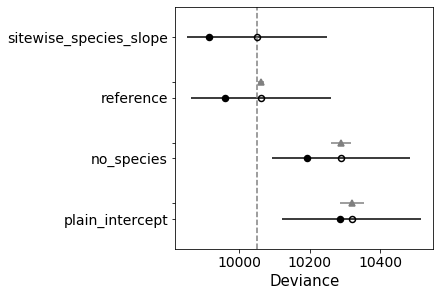

In [55]:

PM.compareplot(model_comparison);

This informative plot shows that the sitewise species slope does not perform better than the reference, hence the extra value from the more complex model structure is limited. In contrast, neglecting site-specific intercepts or leaving out species will make the model less appropriate. This justifies my selection of the reference model for the *Patella* problem.

Note that a comparison like this actually would have to be done with all the model parameters (leaving out habitats, multi-level habitats, ...), and for each outcome variable (i.e. observable) separately. I restricted it here to the `species`, for the purpose of demonstration.

<hr>

# Conclusions <a class="anchor" id="conclusions"></a> 
([^](#toc) top) 


## ...on <i>Patellae</i>
Returning to the initial hypotheses:

**Hypothesis $H_0$: _Patella depressa_ has a lower height ratio than _Patella vulgata_.**

Let's review the outcome of the reference model for $H_0$.

In [56]:
reference_model.Summary().loc['log_height_ratio', :]

/usr/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  mc_error  \
parameter                                                               
dof__0                                      10.85  4.43e+00  5.93e-02   
habitat exposed $\rightarrow$ rockpool__0    0.04  1.52e-02  2.97e-04   
habitat exposed $\rightarrow$ sheltered__0   0.13  1.34e-02  2.38e-04   
intercept__0                                -1.44  2.17e-02  3.94e-04   
residual__0                                  0.16  6.34e-03  9.02e-05   
species depressa $\rightarrow$ vulgata__0    0.12  1.16e-02  1.77e-04   

                                            hpd_2.5  hpd_97.5    n_eff  Rhat  
parameter                                                                     
dof__0                                         5.22     19.15  4108.97   1.0  
habitat exposed $\rightarrow$ rockpool__0      0.02      0.07  2429.20   1.0  
habitat exposed $\rightarrow$ sheltered__0     0.11      0.16  2768.19   1.0  
intercept__0                                  -1.48     -1.40  2796.26   1.0  
residual__0                                    0.14      0.17  5054.94   1.0  
species depressa $\rightarrow$ vulgata__0      0.09      0.14  4320.35   1.0

Indeed, the height ratio of *vulgata* seems to be higher, and the credible interval (95% HPD) excludes the zero. Hence, there is a "statistically significant" difference in mean height between these species. 

However, modeling (as opposed to hypothesis testing) includes an estimate of the effect magnitude. Thus, the effect size and the residual need to be considered. The magnitude of the species difference is moderate: it amounts to $0.12$, the intercept is $-1.44$. The residual, a measure for the variation which remains unexplained, exceeds the species slope (for example, the age of the limpet could be a conttributing effect hidden in this variability). On the other hand, the habitat slopes are in the order of magnitude of the species slope, so both might be of equal relevance. 

I would conclude that the species difference in this parameter is confirmed, but it is of statistical nature (and in consequence it cannot be used as a diagnostic character for species determination). The outcomes are consistent with the outcome using `statsmodels` framework, which I leave as a homework for interested readers to confirm.


**Hypothesis $G_0$: _Patella vulgata_ are larger than _Patella depressa_, i.e. have a higher PC1 value.**



In [57]:
reference_model.Summary().loc['PC1', :]

mean     sd  mc_error  hpd_2.5  \
parameter                                                                     
dof__0                                      51.78  21.45  2.50e-01    15.73   
habitat exposed $\rightarrow$ rockpool__0   14.07   0.71  1.31e-02    12.69   
habitat exposed $\rightarrow$ sheltered__0  11.20   0.65  1.04e-02     9.93   
intercept__0                                -8.39   1.23  1.98e-02   -10.73   
residual__0                                  8.06   0.20  2.40e-03     7.67   
species depressa $\rightarrow$ vulgata__0    0.56   0.55  7.31e-03    -0.54   

                                            hpd_97.5    n_eff  Rhat  
parameter                                                            
dof__0                                         92.71  7643.74   1.0  
habitat exposed $\rightarrow$ rockpool__0      15.43  3074.34   1.0  
habitat exposed $\rightarrow$ sheltered__0     12.47  3800.42   1.0  
intercept__0                                   -5.96  4253.27   1.0  
residual__0                                     8.46  8320.95   1.0  
species depressa $\rightarrow$ vulgata__0       1.62  5035.43   1.0

Species clearly has no effect (because zero is included in the interval between hpd_2.5 and hpd_97.5).

## ... on Statistics


Above, I have exemplified my typical workflow for a statistical analysis. I will summarize it again.

- Visually inspect the data by creative plotting. Understand the data structure.
- Multivariate transformations, such as PCA (use with caution).
- Define working hypotheses.
- Design models that mimic the structure of the data. 
- Use `statsmodels` to select key models and refine them coarsely. 
- Use `pymc3` to compute and sample reference models. 
- Careful prior design (not shown, but important).
- Additionally, compute alternative models that alter the parameter representation or composition. This can be done in an incremental and decremental systematic process, adding or removing parameters successively from a reference model. 
- Perform posterior checks. 
- Compare the models. Refine, and optionally return to "model design".
- Presentation of the outcome.


Some aspects which I did not (sufficiently) cover (yet):
- prior design
- identifying and handling sampler convergence issues
- samplers and sampler settings
- shrinkage
- correlated model parameters and the LKJ prior structure
- saving `pymc` models to disk


Pay particular attention to the terminology, which varies considerably across statisticians. I herein attempted to choose unambiguous terms, but they might not be the most abundant ones.

As you see, modeling is a complex and interesting process, even for the simple example presented here. I have tried to highlight some pitfalls. I have also tried to point out the use of object-oriented programming in the framework of statistics, and provided code block that can be freely reused and adapted for different purposes.

As usual, I appreciate your feedback, questions, and comments.


 <a class="anchor" id="comments"></a> 
([^](#toc) top) 

# <u>Changelog</u>
2019/09/27: added normality assessment